# **noisOut:** Denoising Diffusion Probabilistic Models

In [1]:
import os

import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)
torch.manual_seed(0)

### Dataset Investigation

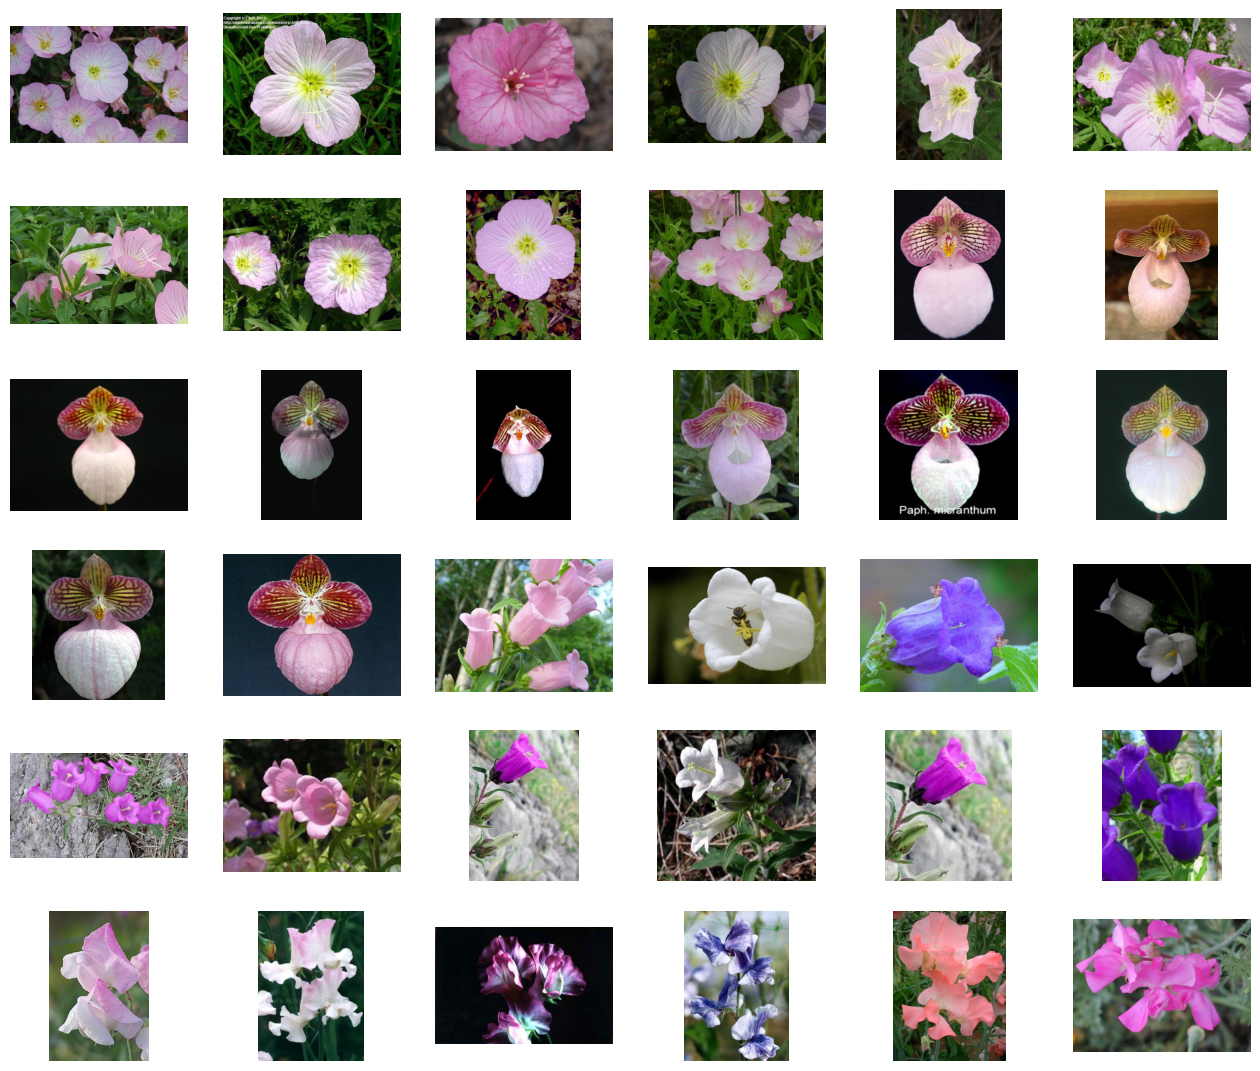

In [3]:
def show_images(dataset, num_samples=36, cols=6):
    rows = num_samples//cols + 1

    plt.figure(figsize=(16, 16))
    for i in range(num_samples):
        image, target = dataset[i]
        image = image.permute(1, 2, 0)
        image = image.numpy()
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

dataset = torchvision.datasets.Flowers102('./data', transform=torchvision.transforms.ToTensor(), download=True)
show_images(dataset)

In [4]:
IMG_SIZE = 32
BATCH_SIZE = 8

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [6]:
def load_transformed_dataset():
    data_transforms = [
        torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),                  # [ 0, 1]
        torchvision.transforms.Lambda(lambda t: t*2 - 1)    # [-1, 1]
    ]

    data_transform = torchvision.transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102('./data', download=True, transform=data_transform, split='train')
    valid = torchvision.datasets.Flowers102('./data', download=True, transform=data_transform, split='val')
    test = torchvision.datasets.Flowers102('./data', download=True, transform=data_transform, split='test')
    return torch.utils.data.ConcatDataset([train, valid, test])

def load_reverse_transformed_dataset(images):
    reverse_transforms = [
        torchvision.transforms.Lambda(lambda t: (t+1) / 2), # [0, 1]
        torchvision.transforms.ToPILImage()
    ]

    reverse_transform = torchvision.transforms.Compose(reverse_transforms)

    return reverse_transform(images[0])

def show_images(pictures):
    num_pictures = len(pictures)
    fig, axes = plt.subplots(1, num_pictures, figsize=(num_pictures * 2, 2))

    if num_pictures == 1:
        axes = [axes]

    for idx, image in enumerate(pictures):
        ax = axes[idx]
        ax.imshow(image.permute(1, 2, 0).cpu().numpy() if isinstance(image, torch.Tensor) else image)
        ax.axis('off')

    plt.show()

In [7]:
dataset = load_transformed_dataset()
dataloader = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True, drop_last=True)
dataloader

### **Diffusion Closed Form**

In [8]:
def beta_schedule(time_steps, start=0.0001, end=0.02, device='cpu'):
    return torch.linspace(start, end, time_steps, device=device)

T = 10

betas = beta_schedule(T, device=device)
betas_cumprod = torch.cumprod(betas, 0)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, 0)

sqrt_alphas = torch.sqrt(alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

sqrt_betas = torch.sqrt(betas)
sqrt_betas_cumprod = torch.sqrt(betas_cumprod)

one_minus_alphas_cumprod = 1. - alphas_cumprod
one_minus_betas_cumprod = 1. - betas_cumprod

sqrt_one_minus_alphas_cumprod = torch.sqrt(one_minus_alphas_cumprod)
sqrt_one_minus_betas_cumprod = torch.sqrt(one_minus_betas_cumprod)

variance = torch.zeros(T, device=device)
variance[1:] = betas[1:] * one_minus_alphas_cumprod[:-1] / one_minus_alphas_cumprod[1:]

In [9]:
next(iter(dataloader))[0].numpy()   # (B, C, H, W)

array([[[[-0.12941176, -0.34117645, -0.42745095, ...,  0.4901961 ,
           0.2941177 ,  0.4039216 ],
         [ 0.5529412 ,  0.19215691, -0.30196077, ...,  0.6156863 ,
           0.5058824 ,  0.27058828],
         [-0.10588235, -0.45098037, -0.5529412 , ...,  0.05882359,
          -0.0745098 , -0.21568626],
         ...,
         [-0.29411763, -0.2862745 , -0.40392154, ..., -0.3490196 ,
          -0.38039213, -0.4352941 ],
         [-0.3490196 , -0.26274508, -0.41176468, ..., -0.38039213,
          -0.45098037, -0.46666664],
         [-0.5372549 , -0.372549  , -0.41960782, ..., -0.5529412 ,
          -0.5921569 , -0.60784316]],

        [[-0.27843136, -0.32549018, -0.1607843 , ...,  0.20000005,
           0.07450986,  0.15294123],
         [-0.18431371, -0.1372549 , -0.04313725, ...,  0.23921573,
           0.16078436, -0.05098039],
         [-0.49019605, -0.372549  , -0.29411763, ..., -0.04313725,
          -0.05098039, -0.19999999],
         ...,
         [-0.01960784, -0.04313725

In [10]:
next(iter(dataloader))[1].numpy()   # (B, C, H, W)

array([96, 84, 14, 87, 89, 59, 43, 94])

### **The Forward Pass**

In [11]:
def forward_diffusion(x_0, t, device='cpu'):
    """
    forward_diffusion(x_0, t, device='cpu')

    Adds noise to the input image x_0 at the time step(s) specified by the tensor t using the diffusion process.

    Parameters:
        x_0 (Tensor): The input image with shape (B, C, H, W).
        t (Tensor): A tensor of time steps in the diffusion process. shape = (1,) or (B,)
        device (str, optional): Device for computation ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        x_t (Tensor): Noisy image after diffusion, same shape as x_0.
        noise (Tensor): The noise added to x_0.

    Details:
        Generates noise and computes the noisy image as:
        x_t = sqrt(alpha_t) * x_0 + sqrt(1 - alpha_t) * noise
    """

    B, C, H, W = x_0.shape

    noise = torch.randn_like(x_0, device=device)                                                          # (B, C, H, W)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, *[1]*(len(x_0.shape)-1))                      # (1, 1, 1, 1) or (B, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, *[1]*(len(x_0.shape)-1))  # (1, 1, 1, 1) or (B, 1, 1, 1)

    x_0 = x_0.to(device)
    noise = noise.to(device)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t.to(device)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t.to(device)

    # re-parameterization trick
    return sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise, noise                   # (B, C, H, W)

In [12]:
NUM_IMAGES = 10

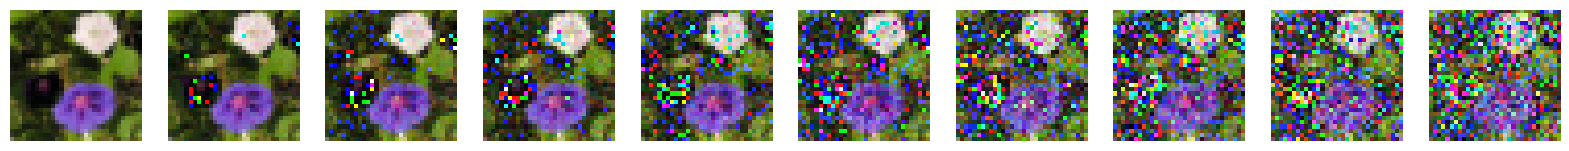

In [13]:
batch = next(iter(dataloader))
batch_images = batch[0]
batch_labels = batch[1]

num_images = NUM_IMAGES
step_size = T // num_images

pictures = []
for idx, t in enumerate(range(0, T, step_size)):
    t = torch.tensor([t])
    images, noises = forward_diffusion(batch_images, t)
    image = load_reverse_transformed_dataset(images)
    pictures.append(image)

show_images(pictures)

### **The Backward Pass**

In [14]:
class SinusodialPositionEmbeddings(torch.nn.Module):
    """
    SinusoidalPositionEmbeddings(torch.nn.Module)

    A module that generates sinusoidal position embeddings for a given time step tensor t. The embeddings are based on the sine and cosine functions, commonly used in transformer architectures to encode positional information.

    Parameters:
        t_dim (int): The dimensionality of the position embeddings. The output embedding will have a size of (t, t_dim), where `t` is the batch size or number of time steps.

    Methods:
        forward(t):
            Generates the sinusoidal embeddings for the input tensor `t`.

            Parameters:
                t (Tensor): A tensor of shape (t,) representing the time steps. The embeddings are computed for each time step.

            Returns:
                Tensor: A tensor of shape (t, t_dim) containing the position embeddings, where each time step is encoded using both sine and cosine functions.

    Details:
        - The embeddings are calculated as:
          emb = [sin(x), cos(x)], where x is scaled based on the time step and the positional dimension.
        - The time step tensor `t` is scaled using a frequency determined by the dimensionality of the embeddings (`t_dim`).
    """

    def __init__(self, t_dim):
        super().__init__()
        self.t_dim = t_dim

    def forward(self, t):
        t_dim = self.t_dim
        h_dim = self.t_dim//2
        i = torch.arange(h_dim, device=t.device, dtype=t.dtype) # (h_dim, )
        i = i.unsqueeze(0)                                      # (1, h_dim)
        t = t.unsqueeze(-1)                                     # (t, 1)
        x = t / (1000 ** (2 * i / self.t_dim))                  # (t, h_dim)

        emb = torch.cat([torch.sin(x)[:, :, None], torch.cos(x)[:, :, None]], dim=-1)   # (t, h_dim*2)
        emb = emb.view(t.shape[0], self.t_dim)                                          # (t, t_dim)
        return emb

In [15]:
TIME_DIM = 1024
TIME_STEPS = 128

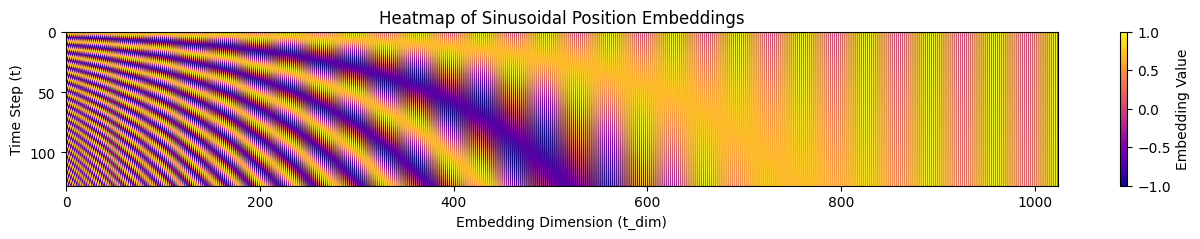

In [16]:
def show_heat_map(t_dim=TIME_DIM, t_steps=TIME_STEPS):
    embeddings = SinusodialPositionEmbeddings(t_dim)

    time_steps = torch.arange(0, t_steps)
    emb_matrix = embeddings(time_steps).detach().numpy()

    plt.figure(figsize=(16, 2))
    plt.imshow(emb_matrix, cmap='plasma', aspect='auto')
    plt.colorbar(label='Embedding Value')
    plt.title('Heatmap of Sinusoidal Position Embeddings')
    plt.xlabel('Embedding Dimension (t_dim)')
    plt.ylabel('Time Step (t)')
    plt.show();

show_heat_map(TIME_DIM, TIME_STEPS)

In [17]:
class Block(torch.nn.Module):

    def __init__(self, channels_in, channels_out, t_dim, sampling):
        super().__init__()

        self.t_mlp = torch.nn.Linear(t_dim, channels_out)
        self.sampling = sampling

        if sampling == 'up':
            self.conv_1 = torch.nn.Conv2d(2 * channels_in, channels_out, kernel_size=3, stride=2, padding=1)
            self.transform = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        if sampling == 'down':
            self.conv_1 = torch.nn.ConvTranspose2d(1 * channels_in, channels_out, kernel_size=3, stride=2, padding=1)
            self.transform = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        self.bnorm_1 = torch.nn.BatchNorm2d(channels_out)

        self.conv_2 = torch.nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1)
        self.bnorm_2 = torch.nn.BatchNorm2d(channels_out)

        self.relu = torch.nn.ReLU()

    def forward(self, x, t):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.bnorm_1(x)

        t = self.t_mlp(t)
        t = t.view(t.shape[0], t.shape[1], 1, 1)

        x = x + t

        x = self.conv_2(x)
        x = self.relu(x)
        x = self.bnorm_2(x)

        x = self.transform(x)

        return x

In [18]:
class UNet(torch.nn.Module):

    def __init__(self, img_channels, t_dim):
        super().__init__()

        self.img_channels_in = img_channels
        self.img_channels_out = img_channels

        self.u_channels = (64, 128, 256)
        self.d_channels = (256, 128, 64)

        self.t_dim = t_dim

        self.t_mlp = torch.nn.Sequential(
            SinusodialPositionEmbeddings(self.t_dim),
            torch.nn.Linear(self.t_dim, self.t_dim),
            torch.nn.ReLU()
        )

        self.conv_in = torch.nn.Conv2d(self.img_channels_in, self.d_channels[0], kernel_size=3, stride=1, padding=1)

        self.d_sampling_blocks = torch.nn.ModuleList(
            [
                Block(self.d_channels[i], self.d_channels[i+1], t_dim, 'down')
                for i in range(len(self.d_channels)-1)
            ]
        )

        self.u_sampling_blocks = torch.nn.ModuleList(
            [
                Block(self.u_channels[i], self.u_channels[i+1], t_dim, 'up')
                for i in range(len(self.u_channels)-1)
            ]
        )

        self.conv_out = torch.nn.Conv2d(self.u_channels[-1], self.img_channels_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x, t):
        t = self.t_mlp(t)

        x = self.conv_in(x)

        residual_blocks = []

        for d_block in self.d_sampling_blocks:
            x = d_block(x, t)                           # (B, C, H, W)
            residual_blocks.append(x)                   # (B, C, H, W)

        for u_block in self.u_sampling_blocks:
            r = residual_blocks.pop()                   # (B, C, H, W)
            x = u_block(torch.cat([x, r], dim=1), t)    # (B, C, H, W)

        x = self.conv_out(x)

        return x

In [19]:
CHANNEL_COUNT = 3
TIME_DIM = 32

In [20]:
model = UNet(CHANNEL_COUNT, TIME_DIM)
print(f'Number of parameters: {sum(p.numel() for p in model.parameters()):,}')
model.to(device)
model

Number of parameters: 2,987,299


UNet(
  (t_mlp): Sequential(
    (0): SinusodialPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv_in): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (d_sampling_blocks): ModuleList(
    (0): Block(
      (t_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv_1): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (t_mlp): Linear(in_features=32, out_features=64, bias=True)
      (conv_1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(

### **Loss Function**

In [21]:
def calculate_loss(model, x_0, t):
    """
    calculate_loss(model, x_0, t)

    Calculates the loss for a diffusion model by comparing the predicted noise at a given time step with the true noise added during the forward diffusion process.

    Parameters:
        model (torch.nn.Module): The diffusion model that predicts the noise for the noisy image at time step t.
        x_0 (Tensor): The original input image (batch, channels, height, width) at time step t=0.
        t (Tensor): The tensor of time steps, typically of shape (B,), where B is the batch size.

    Returns:
        Tensor: The mean squared error (MSE) loss between the model's predicted noise and the true noise added during forward diffusion.

    Details:
        - The forward diffusion process is applied to `x_0` to generate the noisy image `x_t` and the corresponding noise.
        - The model predicts the noise `x_t_` for the noisy image `x_t` at time step `t`.
        - The loss is computed as the MSE between the model's prediction (`x_t_`) and the true noise (`noise`).
    """

    x_t, noise = forward_diffusion(x_0, t, device)    # (B, C, H, W)

    noise_ = model(x_t, t)

    loss = torch.nn.functional.mse_loss(noise_, noise)
    return loss

### **Inference Sampling**

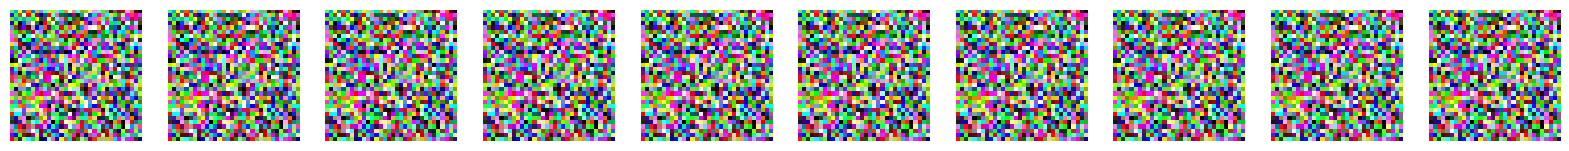

In [22]:
@torch.no_grad()
def sample_image():

    @torch.no_grad()
    def sample_tensor(x_t, t):
        noise_ = model(x_t, t)                                                                                                # (B, C, H, W)

        betas_t = betas[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)                                                       # (1, 1, 1, 1)
        alphas_t = alphas[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)                                                     # (1, 1, 1, 1)
        sqrt_betas_t = sqrt_betas[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)                                             # (1, 1, 1, 1)
        sqrt_alphas_t = sqrt_alphas_cumprod[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)                                   # (1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)       # (1, 1, 1, 1)

        mean_t = ((x_t / sqrt_alphas_t) - betas_t * noise_ / (sqrt_one_minus_alphas_cumprod_t * sqrt_alphas_t)).to(device)    # (1, 1, 1, 1)
        variance_t = variance[t].view(-1, *[1]*(len(x_t.shape)-1)).to(device)

        return mean_t if t == 0 else (mean_t + (torch.sqrt(variance_t) * torch.randn_like(x_t, device=device)))               # (B, C, H, W)

    img_size = IMG_SIZE

    img = torch.randn((1, CHANNEL_COUNT, img_size, img_size), device=device)                                                  # (1, C, H, W)

    num_images = NUM_IMAGES
    step_size = T // num_images

    pictures = []
    for t in range(T)[::-1]:
        t = torch.tensor([t], device=device)                                    # (1, )
        img = sample_tensor(img, t)                                             # (1, C, H, W)
        img = torch.clamp(img, -1.0, 1.0)                                       # (1, C, H, W)
        image = load_reverse_transformed_dataset(img)                           # (1, C, H, W)
        pictures.append(image)

    show_images(pictures)

sample_image()

### **Training Loop**

Epoch:      1 | Step:    100 | Loss: 0.967683
Epoch:      1 | Step:    200 | Loss: 0.348151
Epoch:      1 | Step:    300 | Loss: 0.445116
Epoch:      1 | Step:    400 | Loss: 0.524576
Epoch:      1 | Step:    500 | Loss: 0.322935
Epoch:      1 | Step:    600 | Loss: 0.389232
Epoch:      1 | Step:    700 | Loss: 0.498314
Epoch:      1 | Step:    800 | Loss: 0.212679
Epoch:      1 | Step:    900 | Loss: 0.257656
Epoch:      1 | Step:   1000 | Loss: 0.227654


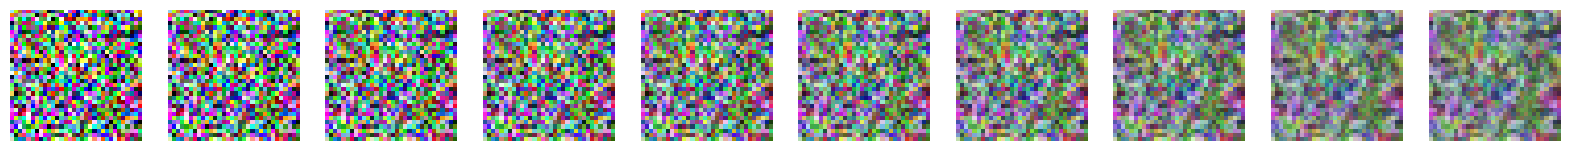

Epoch:      2 | Step:    100 | Loss: 0.451593
Epoch:      2 | Step:    200 | Loss: 0.250235
Epoch:      2 | Step:    300 | Loss: 0.258254
Epoch:      2 | Step:    400 | Loss: 0.237128
Epoch:      2 | Step:    500 | Loss: 0.260171
Epoch:      2 | Step:    600 | Loss: 0.362961
Epoch:      2 | Step:    700 | Loss: 0.420117
Epoch:      2 | Step:    800 | Loss: 0.255565
Epoch:      2 | Step:    900 | Loss: 0.443453
Epoch:      2 | Step:   1000 | Loss: 0.210362


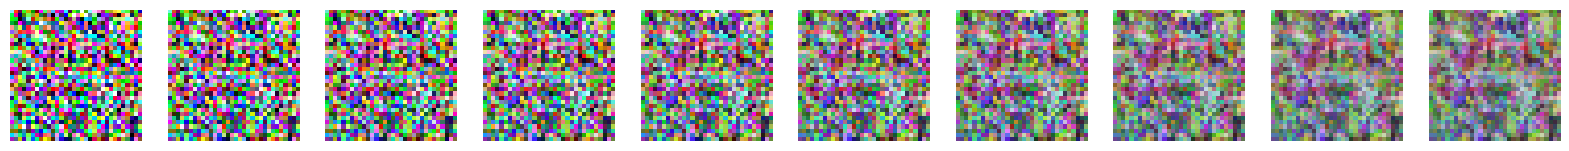

Epoch:      3 | Step:    100 | Loss: 0.221121
Epoch:      3 | Step:    200 | Loss: 0.359652
Epoch:      3 | Step:    300 | Loss: 0.412251
Epoch:      3 | Step:    400 | Loss: 0.451814
Epoch:      3 | Step:    500 | Loss: 0.323758
Epoch:      3 | Step:    600 | Loss: 0.218071
Epoch:      3 | Step:    700 | Loss: 0.165065
Epoch:      3 | Step:    800 | Loss: 0.193358
Epoch:      3 | Step:    900 | Loss: 0.263190
Epoch:      3 | Step:   1000 | Loss: 0.237083


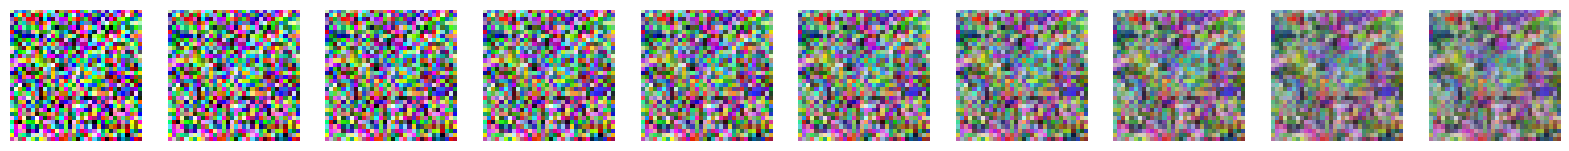

Epoch:      4 | Step:    100 | Loss: 0.202401
Epoch:      4 | Step:    200 | Loss: 0.300788
Epoch:      4 | Step:    300 | Loss: 0.313901
Epoch:      4 | Step:    400 | Loss: 0.280188
Epoch:      4 | Step:    500 | Loss: 0.304062
Epoch:      4 | Step:    600 | Loss: 0.357876
Epoch:      4 | Step:    700 | Loss: 0.327368
Epoch:      4 | Step:    800 | Loss: 0.338757
Epoch:      4 | Step:    900 | Loss: 0.264446
Epoch:      4 | Step:   1000 | Loss: 0.322416


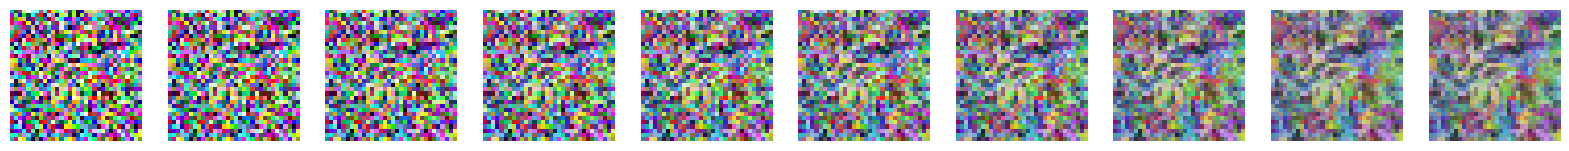

Epoch:      5 | Step:    100 | Loss: 0.302174
Epoch:      5 | Step:    200 | Loss: 0.254057
Epoch:      5 | Step:    300 | Loss: 0.382111
Epoch:      5 | Step:    400 | Loss: 0.272154
Epoch:      5 | Step:    500 | Loss: 0.352657
Epoch:      5 | Step:    600 | Loss: 0.213598
Epoch:      5 | Step:    700 | Loss: 0.269494
Epoch:      5 | Step:    800 | Loss: 0.240275
Epoch:      5 | Step:    900 | Loss: 0.217667
Epoch:      5 | Step:   1000 | Loss: 0.379902


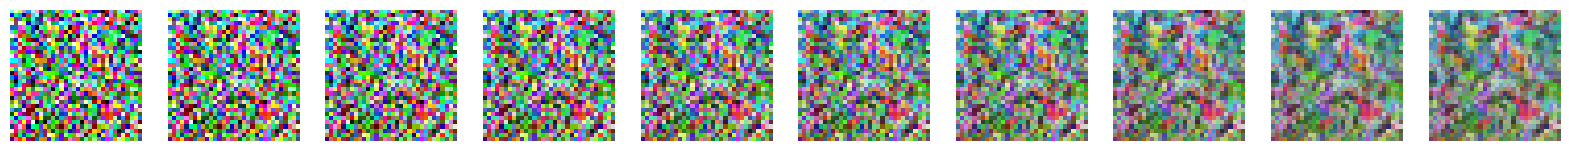

In [23]:
epochs = 5
total_steps = epochs * len(dataloader)

losses = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=(1-1e-3))

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        batch_images = batch[0]
        batch_labels = batch[1]

        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE, ), device=device, dtype=torch.long)  # (B, )

        loss = calculate_loss(model, batch_images, t)                             # (B, )
        loss.backward()

        optimizer.step()
        scheduler.step()

        losses.append(loss.item())

        if ((step+1) % 100 == 0):
          print(f'Epoch: {epoch+1:6d} | Step: {step+1:6d} | Loss: {loss.item():.6f}')

    sample_image()

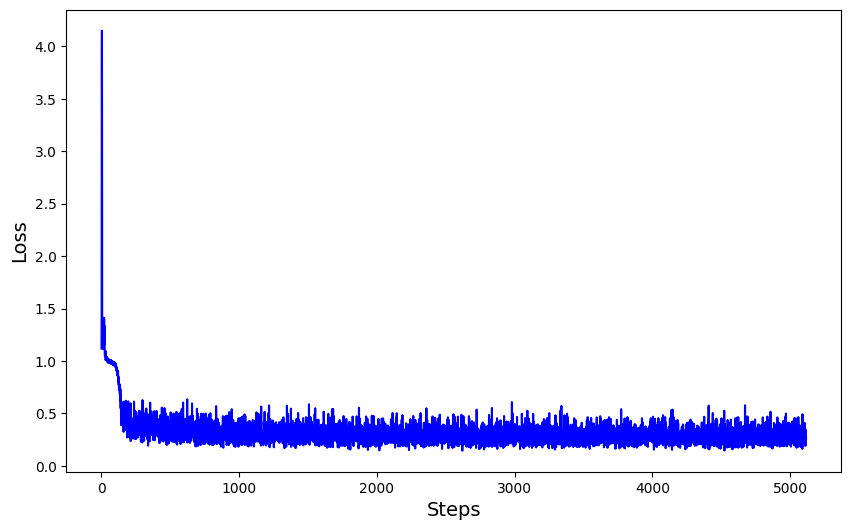

In [24]:
steps = range(1, len(losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, color='blue')
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.show()

In [25]:
dataset_name = 'Flowers102_model.pth'
if not os.path.exists('./models'):
    os.makedirs('./models')

model_path = f'./models/{dataset_name}'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

Model saved to ./models/Flowers102_model.pth
